In [ ]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
'''
@File    :   preprocessor.ipynb
@Time    :   2023/06/27 15:21:22
@Author  :   AVGalapon 
@Contact :   a.v.galapon@umcg.nl
@License :   (C)Copyright 2022-2023, Arthur Galapon
@Desc    :   Convert dose images to nrrd
             Resample to 128x128x128
'''


In [1]:
import os
import fnmatch
import shutil
from tqdm import tqdm
import SimpleITK as sitk
import pre_process_tools
import pydicom as dcm

from utilities import read_json_file

In [2]:
master_json_path = f"/data/galaponav/DBP_newDATA/results_patients_file_random_initial_pos_combined.json"
master_json = read_json_file(master_json_path)

num_processed_patients = len(master_json['patients'])

exception_list = ['DBP_HN006']
data_path = f"/data/galaponav/DBP_newDATA"

pct_dose_list = []
rct_dose_list = []
final_translation_list = []

for px in range(num_processed_patients):
    if master_json['patients'][px]['completed']:
        patient_json_fname = master_json['patients'][px]['filename_results']
        patient_json_path = os.path.join(data_path,patient_json_fname)
        patient_json = read_json_file(patient_json_path)
        num_of_plans = len(patient_json['plans'])

        for i in range(num_of_plans):
            pCT_dose_path = patient_json['plans'][i]['planning_examination']['dose_DICOM_filename']
            
            directory,pCT_dose_fn = os.path.split(pCT_dose_path)
            name, ext = os.path.splitext(pCT_dose_fn)
            pCT_dose_nrrd = os.path.join(data_path,directory,name+'.nrrd')
            
            if not os.path.isfile(pCT_dose_nrrd):
                dose_img = sitk.ReadImage(os.path.join(data_path,pCT_dose_path))
                sitk.WriteImage(dose_img,pCT_dose_nrrd)
            
            pCT_dose_nrrd_resampled = os.path.join(data_path,directory,name+'_resampled.nrrd')
            if not os.path.isfile(pCT_dose_nrrd_resampled):
                pre_process_tools.resample_to_size(pCT_dose_nrrd, pCT_dose_nrrd_resampled, [128,128,128])
                
            num_of_evals = len(patient_json['plans'][i]['evaluation_examinations'])
            for k in range(num_of_evals):
                rct_name = patient_json['plans'][i]['evaluation_examinations'][k]['name']
                
                if rct_name != 'pCTp0': # Exclude pCTp0 - WIP
                    num_of_opt_case = len(patient_json['plans'][i]['evaluation_examinations'][k]['optimization_cases'])
                    for l in range(num_of_opt_case):
                        if patient_json['plans'][i]['evaluation_examinations'][k]['optimization_cases'][l]['completed'] == True:
                            rct_dose_path = patient_json['plans'][i]['evaluation_examinations'][k]['optimization_cases'][l]['gradient_descent_result']['dose_DICOM_filename']
                            
                            directory2, rct_dose_fn = os.path.split(rct_dose_path)
                            name2, ext2 = os.path.splitext(rct_dose_fn)
                            rCT_dose_nrrd = os.path.join(data_path,directory2,name2+'.nrrd')
                            
                            if not os.path.isfile(rCT_dose_nrrd):
                                rct_dose_img = sitk.ReadImage(os.path.join(data_path,rct_dose_path))
                                sitk.WriteImage(rct_dose_img,rCT_dose_nrrd)
                            
                            rct_dose_nrrd_resampled = os.path.join(data_path,directory2,name2+'_resampled.nrrd')
                            
                            if not os.path.isfile(rct_dose_nrrd_resampled):
                                pre_process_tools.resample_to_size(rCT_dose_nrrd, rct_dose_nrrd_resampled, [128,128,128])

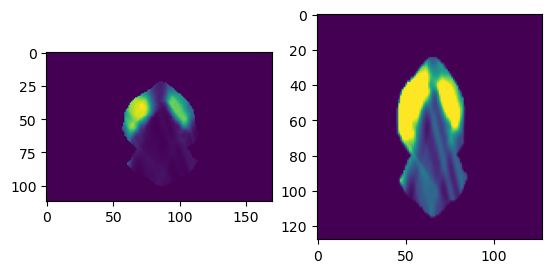

In [5]:
import matplotlib.pyplot as plt

img1 = sitk.ReadImage(rCT_dose_nrrd)
img1 = sitk.GetArrayFromImage(img1)

img2 = sitk.ReadImage(rct_dose_nrrd_resampled)
img2 = sitk.GetArrayFromImage(img2)

plt.subplot(121)
plt.imshow(img1[50])
plt.subplot(122)
plt.imshow(img2[50])

In [6]:
img1.shape

(135, 112, 170)